# PCA 

In [1]:
# modules
import os
import time
import pickle
from tqdm.notebook import tqdm
import numpy as np

# loading word2vec models
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

# plotting
import plotly
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# PCA
from sklearn.decomposition import PCA, KernelPCA

### Loading Pre-trained Word Embeddings
You can find the data in this [link](https://nlp.stanford.edu/projects/glove/)

- I chose this specific dataset as it shows the amazing capabilites of word2vec models to understand the relationship between words. 
 - **word2vec** : 'These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words'. [reference](https://en.wikipedia.org/wiki/Word2vec)

###### Not moaz -> skip the next cell

In [2]:
# mounting gdrive
from google.colab import drive
drive.mount('/gdrive')

# getting the data from my drive
!cp /gdrive/MyDrive/data/glove.6B.100d.txt . 

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


###### **Getting the Embedding Data (might take sometime)**

In [25]:
# downloading the data
if 'glove.6B.100d.txt' not in os.listdir():
  !wget http://nlp.stanford.edu/data/glove.6B.zip

  # unzip the data
  !unzip -q glove.6B.zip

#### Loading the model's data by maually loading it into a dictionary with the keys as the words (strings) and the values are lists of **100 numbers** representing each word.

In [27]:
start_time = time.time()

# dict to save the words:embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    lines = f.readlines()
    for line in tqdm(lines, desc='Indexing word vectors'): # tqdm for visualization
        values = line.split()
        word = values[0] # the word is the first thing in a line
        coefs = np.asarray(values[1:], dtype='float32') # the embeddings, the rest of the line
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors. Time taken: {(time.time() - start_time):.3f}s')


Found 400000 word vectors. Time taken: 10.886s


In [28]:
print(f"Shape of the entire embeddings: ({len(embeddings_index)}, {embeddings_index['the'].shape[0]})")
print(f"Shape of one word embeddings: {embeddings_index['the'].shape}")

Shape of the entire embeddings: (400000, 100)
Shape of one word embeddings: (100,)


**Here we have a total of 400000 words, and each one is represented by 100 numbers**

###### Not moaz -> skip the next cell

In [3]:
# getting the saved word2vec model from my drive 
!cp /gdrive/MyDrive/data/glove2word2vec_model.pt .

### Loading word2vec model using gensim  
- Another way to work with these pre-trained word embeddings is to load them into a word2vec model directly
 - This will make it easy to generate similar words 
 - We can also save the model as `pickle` file for easier loading

First we save the embeddings text file as gensim vectors file

In [30]:
glove2word2vec(glove_input_file='glove.6B.100d.txt', word2vec_output_file='gensim_glove_vectors.txt')

(400000, 100)

Then we load this new file as a **word2vec** model

In [31]:
glove_model = KeyedVectors.load_word2vec_format('gensim_glove_vectors.txt')

In [32]:
# saving the model for faster loading
filename = 'glove2word2vec_model.pt'
pickle.dump(glove_model, open(filename, 'wb'))

### Generating Similar Words

After we saved the model, we can easly load it and use it to generate similar words

In [4]:
# loading the model
filename = 'glove2word2vec_model.pt'
glove_model = pickle.load(open(filename, 'rb'))

**CHOOSE SOME WORDS TO GET MORE SIMILAR WORDS**
- Here we choose some words and format them.
- Then for each word, we make the **word2vec** model generate the **top 5 similar words.**

*choose words that are very different from each other for better visualization :)

In [5]:
input_words = 'queen, bank, teacher, president' # seperated by , or change the next line

In [6]:
user_input = [x.strip() for x in input_words.split(',')]

**Trying on one word**

In [7]:
sim_words = glove_model.most_similar(user_input[0], topn=5)

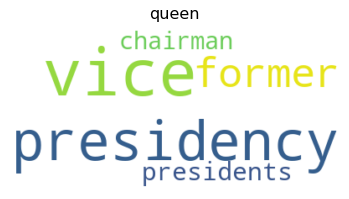

In [19]:
text = ''
for t in np.array(sim_words)[:, 0]:
  text += ' ' + t

wordcloud = WordCloud( background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(user_input[0], fontsize=16)
plt.show()

The model outputs the words and the similarity 

### Getting a list the similar words to all our input words and their embeddings

In [9]:
def append_list(sim_words, words):
    list_of_words = []
    for i in range(len(sim_words)):
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
    return list_of_words

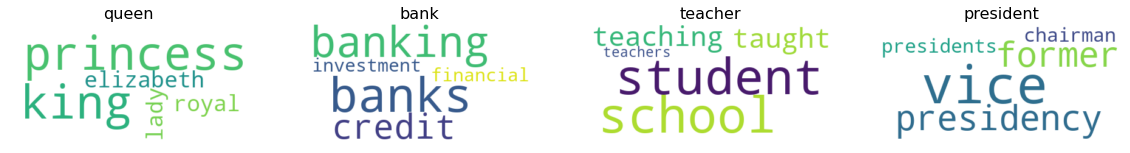

In [17]:
resulted_word = []
fig, axs = plt.subplots(1, len(user_input), figsize=(20, 40))
for i, word in enumerate(user_input):
    sim_words = glove_model.most_similar(word, topn=5)
    sim_words = append_list(sim_words, word)

    # word clouds
    text = ''
    for t in np.array(sim_words)[:, 0]: text += ' ' + t
    wordcloud = WordCloud( background_color='white').generate(text)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(word, fontsize=16)
    
    resulted_word.extend(sim_words)
plt.show()

In [42]:
print('The word | similarity | original word')
resulted_word

The word | similarity | original word


[('princess', 0.7947245240211487, 'queen'),
 ('king', 0.7507690787315369, 'queen'),
 ('elizabeth', 0.7355712652206421, 'queen'),
 ('royal', 0.7065026760101318, 'queen'),
 ('lady', 0.7044796943664551, 'queen'),
 ('banks', 0.8057132959365845, 'bank'),
 ('banking', 0.7530706524848938, 'bank'),
 ('credit', 0.7037603855133057, 'bank'),
 ('investment', 0.6939942836761475, 'bank'),
 ('financial', 0.6777413487434387, 'bank'),
 ('student', 0.8083398938179016, 'teacher'),
 ('school', 0.75455641746521, 'teacher'),
 ('teaching', 0.7521439790725708, 'teacher'),
 ('taught', 0.7411845922470093, 'teacher'),
 ('teachers', 0.7291542887687683, 'teacher'),
 ('vice', 0.828760027885437, 'president'),
 ('presidency', 0.7150214910507202, 'president'),
 ('former', 0.706093966960907, 'president'),
 ('presidents', 0.6961984038352966, 'president'),
 ('chairman', 0.6928698420524597, 'president')]

In [20]:
similar_word = [word[0] for word in resulted_word]
similarity = [word[1] for word in resulted_word]
similar_word.extend(user_input)

In [21]:
print('All words:')
np.array(similar_word)

All words:


array(['princess', 'king', 'elizabeth', 'royal', 'lady', 'banks',
       'banking', 'credit', 'investment', 'financial', 'student',
       'school', 'teaching', 'taught', 'teachers', 'vice', 'presidency',
       'former', 'presidents', 'chairman', 'queen', 'bank', 'teacher',
       'president'], dtype='<U10')

#### Numericalizing the input words to set up the color maps

In [22]:
labels = [word[2] for word in resulted_word]
label_dict = dict([(y, x+1) for x,y in enumerate(set(labels))])
label_dict

{'bank': 3, 'president': 1, 'queen': 2, 'teacher': 4}

In [23]:
color_map = [label_dict[x] for x in labels]
color_map

[2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1]

### Plotting functions 
- Plotting PCA with 3 principal components in 3D
- Plotting PCA with 2 principal components in 2D

In [24]:
def display_pca_3d(model, user_input=None, words=None, label=None, color_map=None, topn=5, sample=10, pca=None):

    
    # getting the word embeddings
    word_vectors = np.array([model[w] for w in words])
    #print(f"word embeddings shape: {word_vectors.shape}")
    
    # the most 3 important principle components
    if pca == None:
        three_dim = PCA(random_state=42).fit_transform(word_vectors)[:,:3]
    else:
        three_dim = pca.fit_transform(word_vectors)[:,:3]
    
    #print(f"word embeddings after PCA shape: {three_dim.shape}")
    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]

    data = []
    count = 0
    
    for i in range (len(user_input)):
                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()

In [25]:
def display_pca_2d(model, user_input=None, words=None, label=None, color_map=None, topn=5, sample=10, pca=None):
    
            
    word_vectors = np.array([model[w] for w in words])
    
    # get the 2 most important principle components
    if pca == None:
        two_dims = PCA(random_state=42).fit_transform(word_vectors)[:,:2]
    else:
        two_dims = pca.fit_transform(word_vectors)[:,:2]
    
    data = []
    count = 0
    
    for i in range(len(user_input)):
        
        trace = go.Scatter(
            x = two_dims[count:count+topn, 0],
            y = two_dims[count:count+topn, 1],
            text = words[count:count+topn],
            name = user_input[i],
            textposition = 'top center',
            textfont_size = 20,
            mode = 'markers+text',
            marker = {
                'size': 10,
                'opacity': 0.8,
                'color': 2,
            }
        )
        
        data.append(trace)
        count += topn
    
    # input words in black
    trace_input = go.Scatter(
        x = two_dims[count:, 0],
        y = two_dims[count:, 1],
        text = words[count:],
        name = 'input words',
        textposition = 'top center',
        textfont_size = 20,
        mode = 'markers+text',
        marker = {
            'size': 10,
            'opacity': 1,
            'color': 'black'
        }
    )
    
    data.append(trace_input)
    
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )
    
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.show()

### PCA 3D and 2D

In [26]:
display_pca_3d(glove_model, user_input, similar_word, labels, color_map)

In [27]:
display_pca_2d(glove_model, user_input, similar_word, labels, color_map)

**Comments on PCA** 
- On 3D all input words are seperated correctly and their similar words are around them but it is hard to talk about the relationship between different input words like the relationship between different words.
 - We can see that **president** and related words are related to **queen** and **bank** and their related words but it is not that clear.

- On 2D the relationships become more clear
 - **president** is in face between **queen** and **bank** and their similar words around all of them.
 - There is also a small indication that the word **chairman** is related more to **bank** and its similar words.
 - We can also see that **student** is somehow close to **credit** as credit here can have 2 meanings the financail one and the academical one.
 
- Overall PCA captures the relationship between each word and its similar words but finds hard to relate all the words together.
 - As it doesn't perserve these relationships or clusters after projection. 
 - Other methods that perserve these relationships are Kernel PCA or TNSE which is used mainly for visualization and I will be talking about them both in this notebook.

### PCA with `Random Solver` 3D and 2D 
this makes **PCA** use a stochastic algorithm called Randomized PCA which is way faster than the normal one as it finds an approximation for the first d principal components. With its complexity: O(m x d<sup>2</sup>) + O(d<sup>3</sup>), instead of O(m x n<sup>2</sup>) + O(n<sup>3</sup>) for the full SVD where **n** is dramatically larger than **d**. 


In [28]:
pca_2 = PCA(random_state=42, svd_solver='randomized', n_components=2)
pca_3 = PCA(random_state=42, svd_solver='randomized', n_components=3)

display_pca_2d(glove_model, user_input, similar_word, labels, color_map, pca=pca_2)
display_pca_3d(glove_model, user_input, similar_word, labels, color_map, pca=pca_3)

### Kernel PCA
- It uses the kernel trick which make it possible to perform complex nonlinear projections for the dimensionality reduction.
- This sometimes allow it to perserve clusters of instances after projection which results in a better visualization than normal PCA
- In the 3D plot the word **prisdent** is very close to the **queen** and other related words.
- And also **teacher** and other related words are in a corner which the other words are somehow closer to each other.

In [29]:
pca_2_k = KernelPCA(random_state=42, kernel='poly', gamma=0.1, n_components=2)
pca_3_k = KernelPCA(random_state=42, kernel='poly', gamma=0.1, n_components=3)

display_pca_3d(glove_model, user_input, similar_word, labels, color_map, pca=pca_3_k)
display_pca_2d(glove_model, user_input, similar_word, labels, color_map, pca=pca_2_k)

# TSNE 

In [30]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE

def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 0, iteration = 0, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]


    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()
    
display_tsne_scatterplot_3D(glove_model, user_input, similar_word, labels, color_map, 5, 500, 10000)

In [31]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE

def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 0, iteration = 0, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]


    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()
    
display_tsne_scatterplot_3D(glove_model, user_input, similar_word, labels, color_map, 5, 500, 10000)